# **Machine Learning Project - Automatic Lithology Interpretation in well logs from Bacia do Recôncavo**

[João Vitor Alves Estrella](https://www.linkedin.com/in/jo%C3%A3o-vitor-alves-estrella/)<br>
February 2024

# **1. Introduction**

Lithology interpretation plays a crucial role in reservoir geophysics, contributing to geological modeling and fluid saturation analysis. However, dealing with extensive well log data and limited interpreter resources can be time-consuming. To address this challenge, I propose an unsupervised machine learning approach, leveraging the K-means clustering algorithm (MacQueen et al., 1967). This method accelerates the interpretation process, enabling interpreters to focus on essential aspects of lithology interpretation. The algorithm partitions well log data into distinct, non-overlapping subsets (clusters) based on data point similarities. I applied this approach to cluster shale and sandstone lithologies in the '7-MP-22-BA' well from Bacia do Recôncavo. 

# **2. Study Area**

The Recôncavo Basin is located in the eastern portion of the State of Bahia, Brazil. 
Northeast Region of Brazil, covers an area of approximately 11,000 km² and 
presents a general orientation that follows the NE-SW trend. It is bordered to the north and 
northwest with the Tucano Basin, by Alto de Aporá; to the south with the 
Camamu, by the Barra fault system; to the east, by the fault system of 
Saviour; and to the west by the Maragogipe Fault.

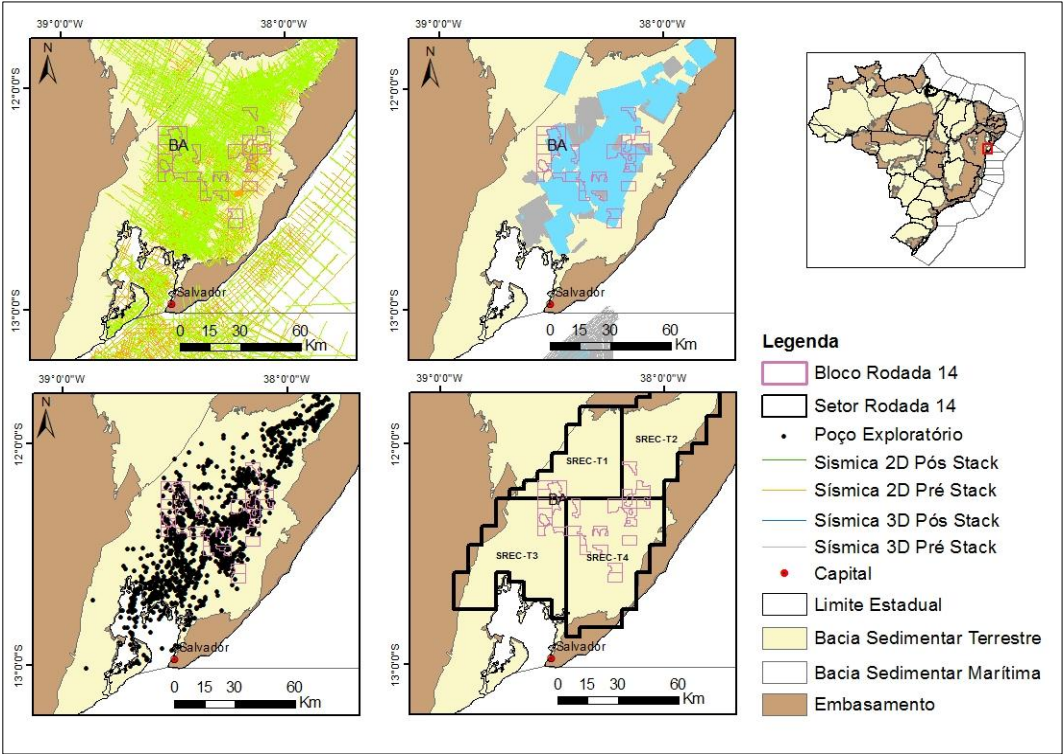

In [167]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import welly
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import defaultdict
from random import uniform
from math import sqrt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
%run kmeans.ipynb

## Import Well

In [168]:
# create an empty list to hold the well objects
wells = []

# read LAS files and create Well objects for each file
las_files = ["data/7-MP-22-BA.las"]
for las_file in las_files:
    well = welly.Well.from_las(las_file)
    wells.append(well)
    

#create a Project object with the list of Well objects
project = welly.Project(wells)

# Set zone interval to get data from wells
basis_depth = range(1421, 3084)

In [169]:
desired_curves = ['NPHI', 'RHOB', 'LITH_NEW']

BRSA_291d_df = project[0].df(keys=desired_curves, basis=basis_depth)

BRSA_291d_df

NPHI      RHOB  LITH_NEW
DEPTH                               
1421.0  0.383625  2.349025      57.0
1422.0  0.398275  2.270175      57.0
1423.0  0.378425  2.361100      57.0
1424.0  0.387050  2.413400      57.0
1425.0  0.409950  2.313700      57.0
...          ...       ...       ...
3079.0  0.071100  2.558500      49.0
3080.0  0.071100  2.558500      49.0
3081.0  0.071100  2.558500      49.0
3082.0  0.071100  2.558500      49.0
3083.0  0.071100  2.558500      49.0

[1663 rows x 3 columns]

## Remove low occurences lithologies

In [170]:
# Rename lithology column for easier access
BRSA_291d_df = BRSA_291d_df.rename(columns={'LITH_NEW': 'LITHO'})
BRSA_291d_df

# Check all lithology types
unique_lithologies = BRSA_291d_df['LITHO'].unique()
unique_lithologies

array([57.  , 49.  , 31.  , 50.25, 54.75, 25.  , 54.  , 49.  , 46.75,
       43.  , 32.25, 56.25, 32.25, 43.  , 31.  , 46.75, 33.  , 52.75,
       54.75, 49.  ])

In [171]:
# Drop low occurences lithologies
desired_lithologies = [57.00, 49.00]
BRSA_291d_df = BRSA_291d_df[BRSA_291d_df['LITHO'].isin(desired_lithologies)]
BRSA_291d_df

NPHI      RHOB  LITHO
DEPTH                            
1421.0  0.383625  2.349025   57.0
1422.0  0.398275  2.270175   57.0
1423.0  0.378425  2.361100   57.0
1424.0  0.387050  2.413400   57.0
1425.0  0.409950  2.313700   57.0
...          ...       ...    ...
3079.0  0.071100  2.558500   49.0
3080.0  0.071100  2.558500   49.0
3081.0  0.071100  2.558500   49.0
3082.0  0.071100  2.558500   49.0
3083.0  0.071100  2.558500   49.0

[1588 rows x 3 columns]

## Edit lithology data

In [172]:
# Substitute lithology codes to indexes that will later represent the clusters values
BRSA_291d_df['LITHO'] = BRSA_291d_df['LITHO'].replace(57.00, 0)
BRSA_291d_df['LITHO'] = BRSA_291d_df['LITHO'].replace(49.00, 1)
print(BRSA_291d_df['LITHO'].unique())

[0. 1.]


Plot data

## Define plot function and configs

In [173]:
colors_lithologies = ['Shale', 'Sandstone']
mpl.rcParams['figure.dpi']= 200
sns.set_style("whitegrid")

# plot configs
cor_dict={0:'green', 1:'blue'}  
labels = ['RHOB', 'NPHI']
xlims = [2, 3]
ylims = [-0.15,0.45]

# Function to plot points by lithologies/clusters
def plot_data_colored_by_groups(groups, assignments_values, dataset, filename, is_save_plot=False):
    fig = plt.figure(figsize=(6,4))
    ax = fig.gca()
    assignments_values = np.array(assignments_values)
    dataset = np.array(dataset)

    for group in groups:
  
        group_mask = np.where(assignments_values == group)[0]
        cluster_points = dataset[group_mask]
        _x = [point[0] for point in cluster_points]
        _y = [point[1] for point in cluster_points]
        ax.scatter(_x, _y, c=cor_dict[group], alpha=0.5)    
        
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])

    # Create custom legend handles with colored circles
    legend_handles = [Patch(color=cor_dict[i], label=f'{colors_lithologies[i]}') for i in range(len(groups))]
    
    # Add central title
    plt.suptitle(filename, fontsize=12)

    # Add legend with custom handles
    ax.legend(handles=legend_handles, title='Lithology', loc='upper right')
    
    if is_save_plot:
        plt.savefig(os.path.join('images/', filename))

    

## Generate points dataset

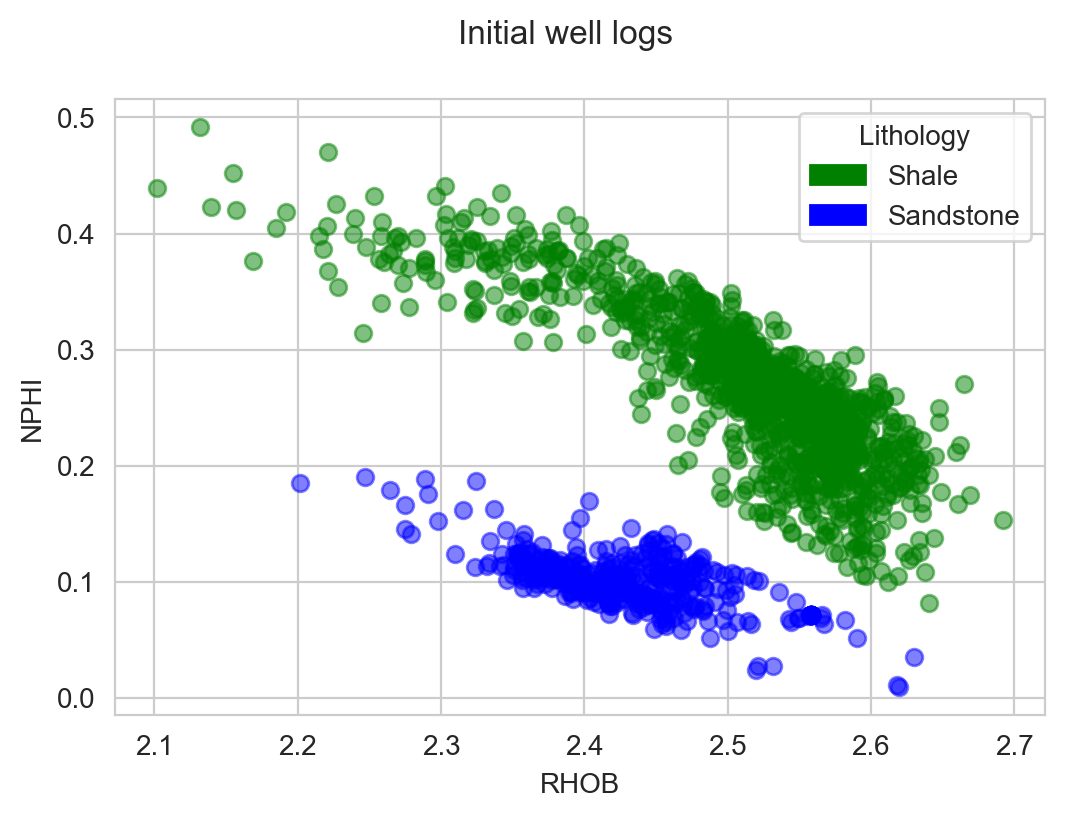

In [174]:
points = BRSA_291d_df[labels].values.tolist()
real_lithologies_assignments = BRSA_291d_df.LITHO.values.tolist()
real_lithologies_assignments = np.array(real_lithologies_assignments)
points = np.array(points)
groups = [0, 1]
plot_data_colored_by_groups(groups, real_lithologies_assignments, points, 'Initial well logs')

## Apply K-means algorithm

iter 9


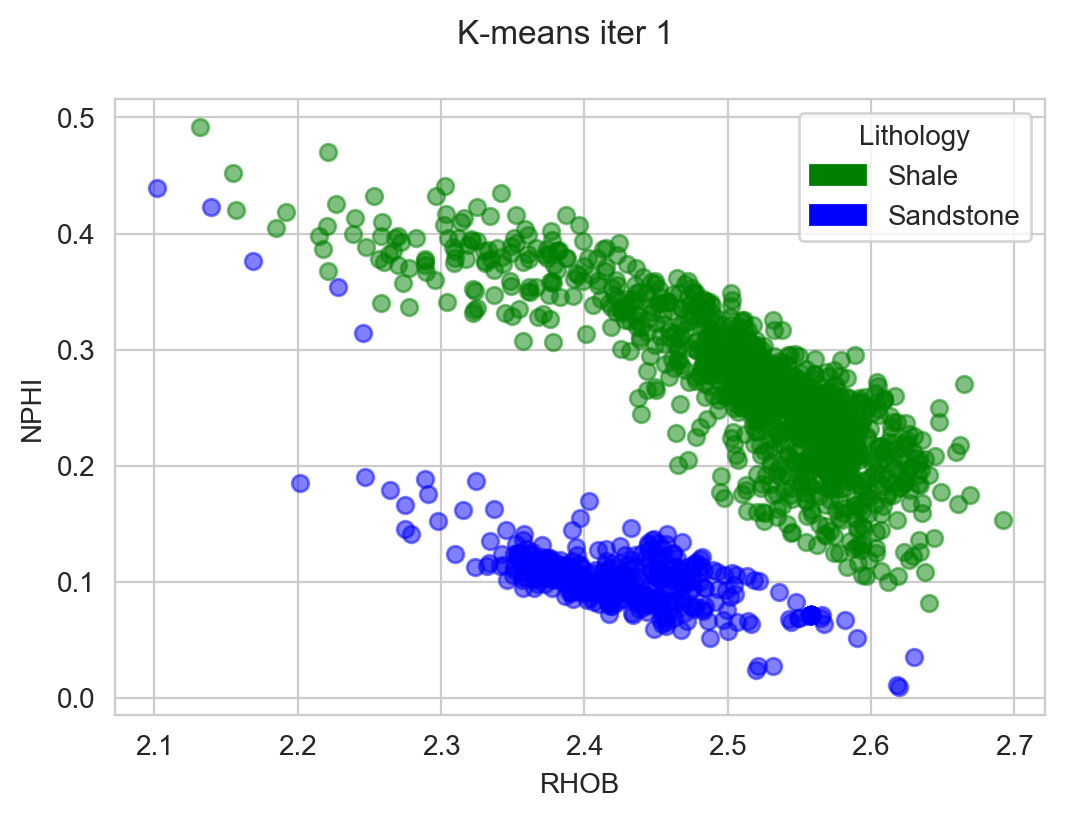

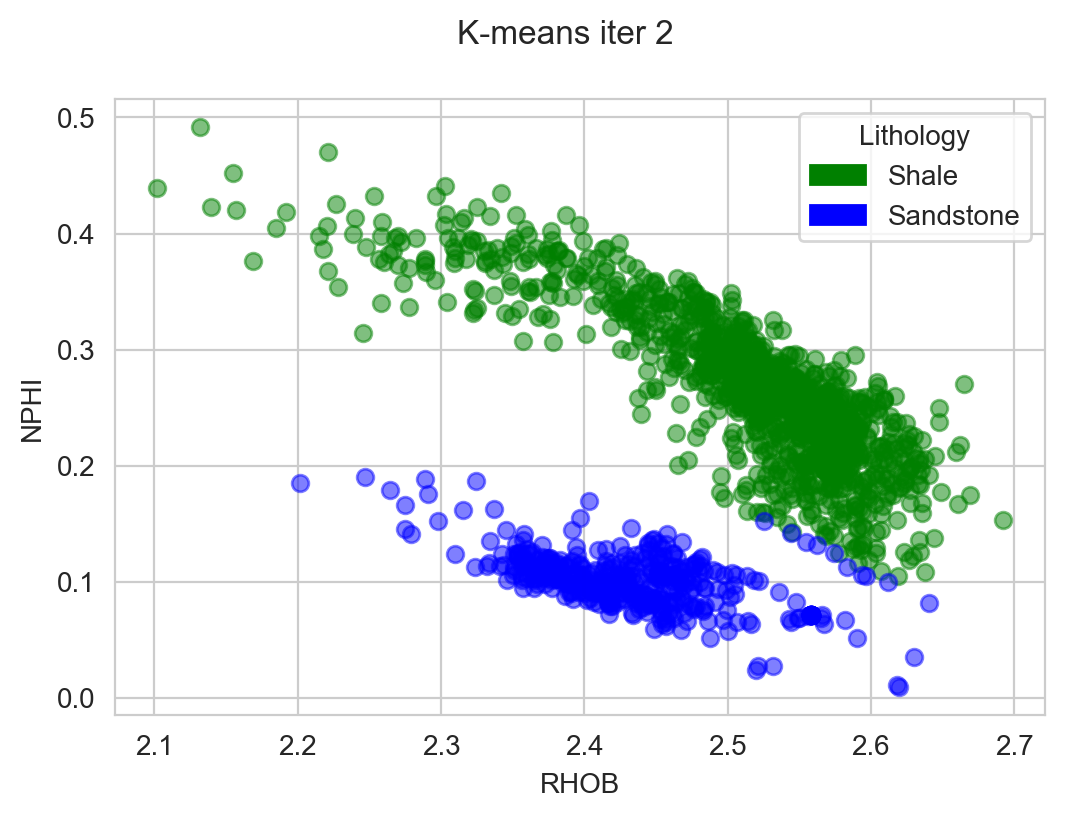

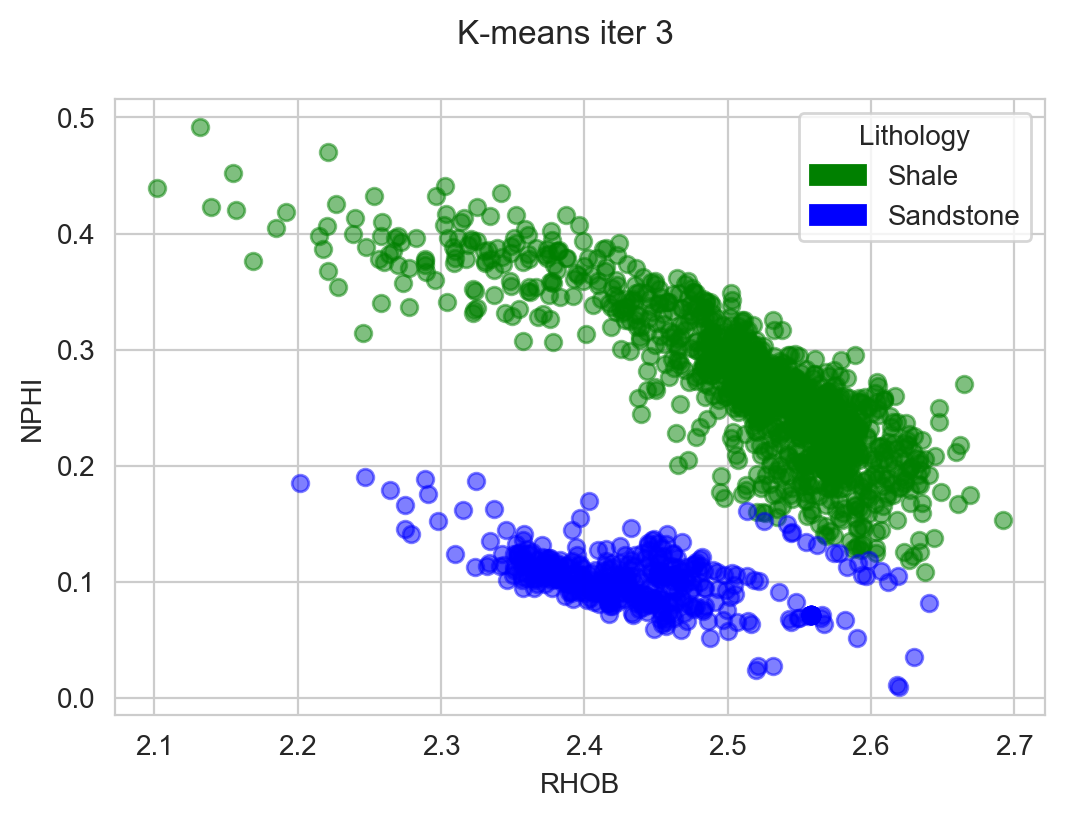

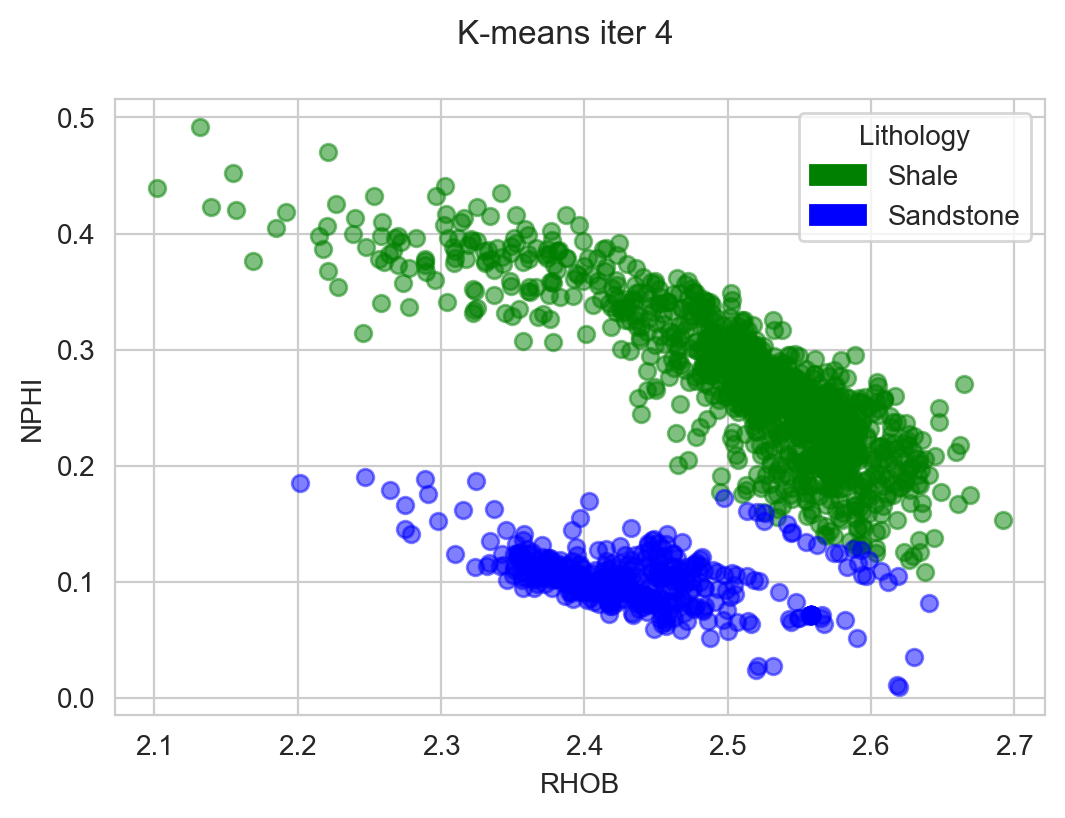

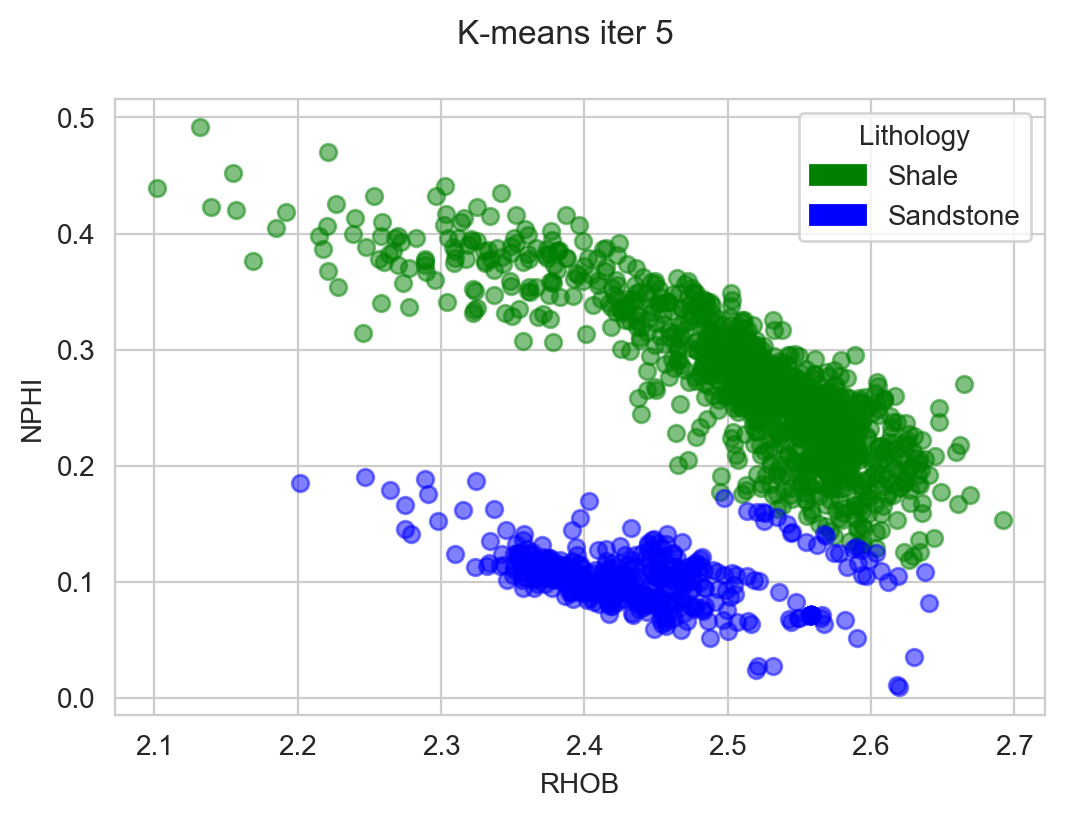

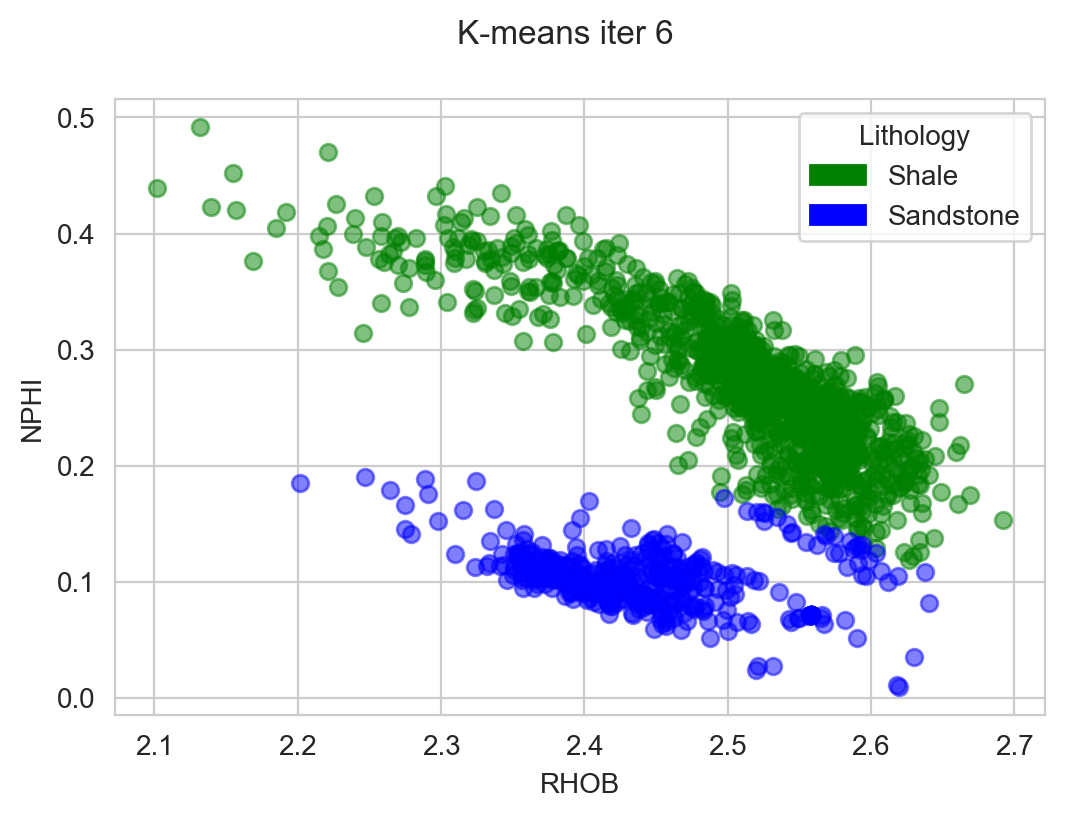

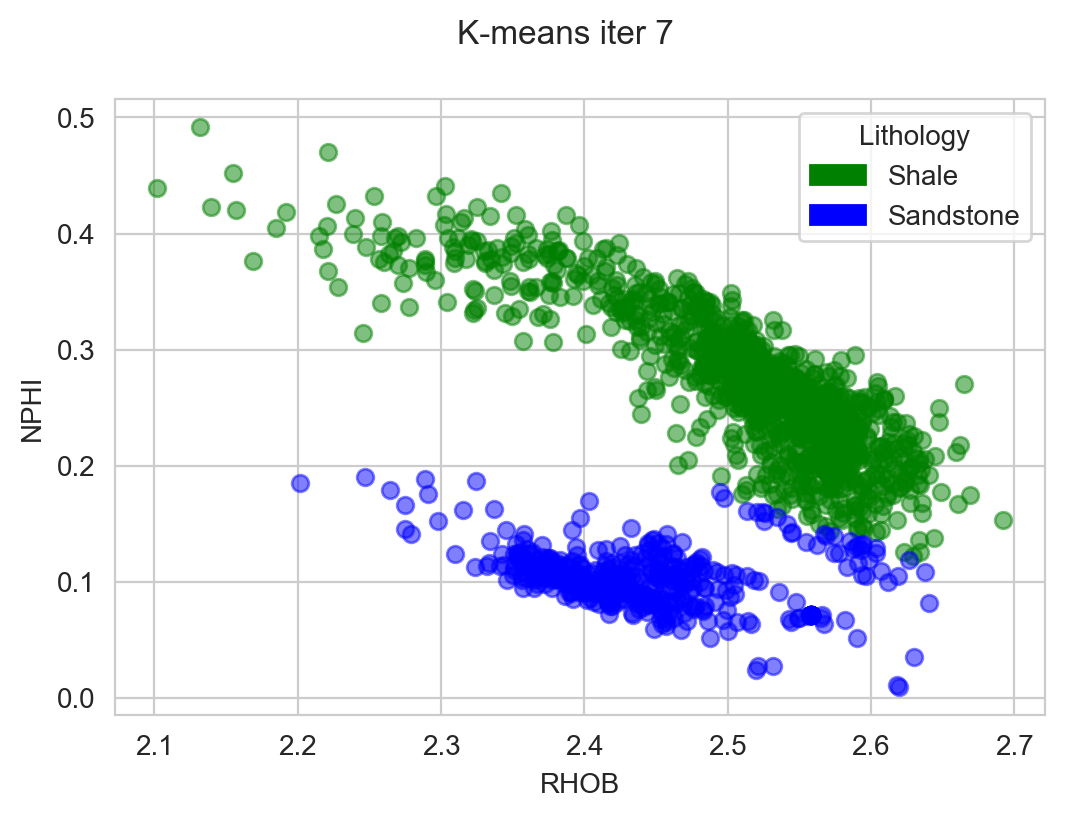

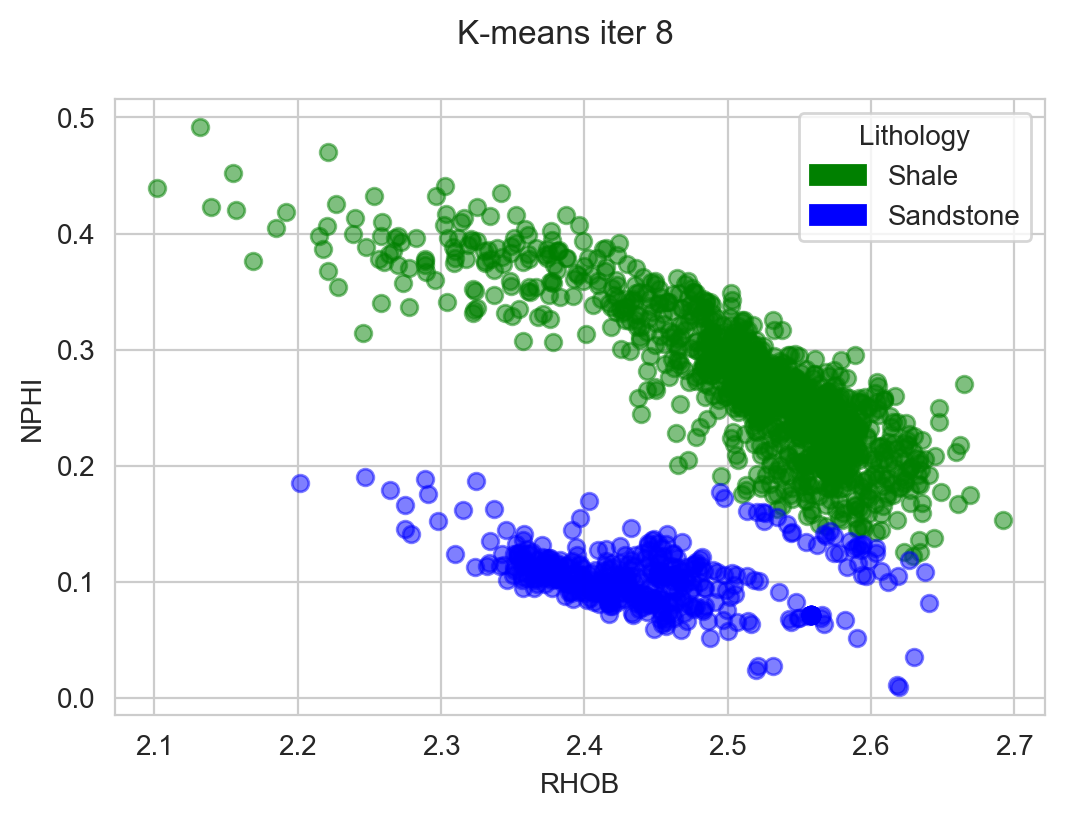

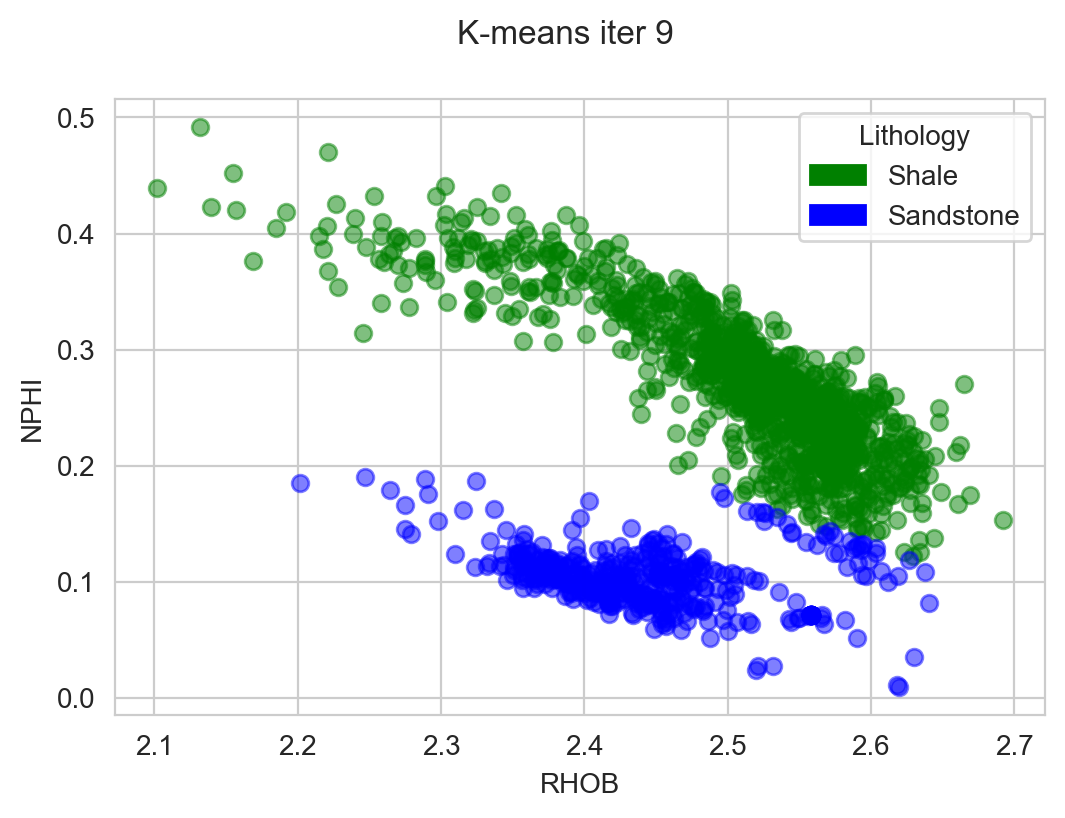

In [175]:
k_means_assignments = cluster_by_kmeans(points, 2)    

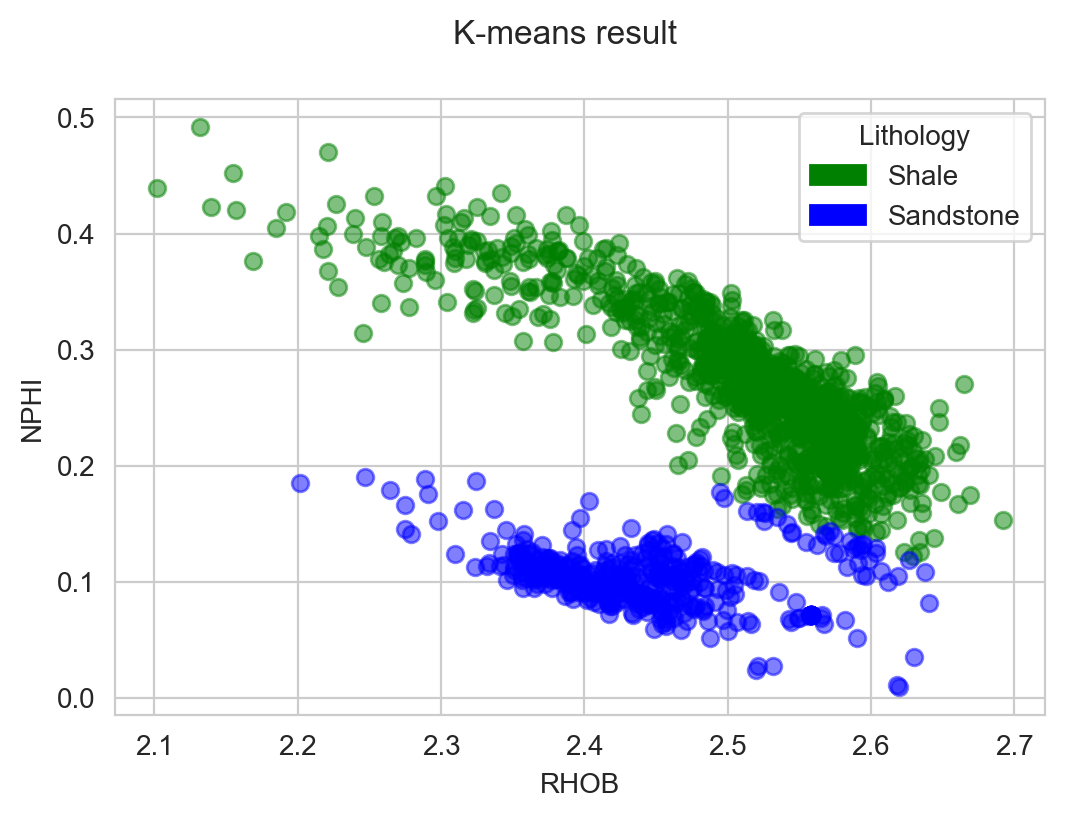

In [176]:
plot_data_colored_by_groups(groups, k_means_assignments, points, 'K-means result')

## Metrics

In [177]:
accuracy = accuracy_score(y_true=real_lithologies_assignments, y_pred=k_means_assignments, normalize=True)
print('accuracy', accuracy)

accuracy 0.97544080604534


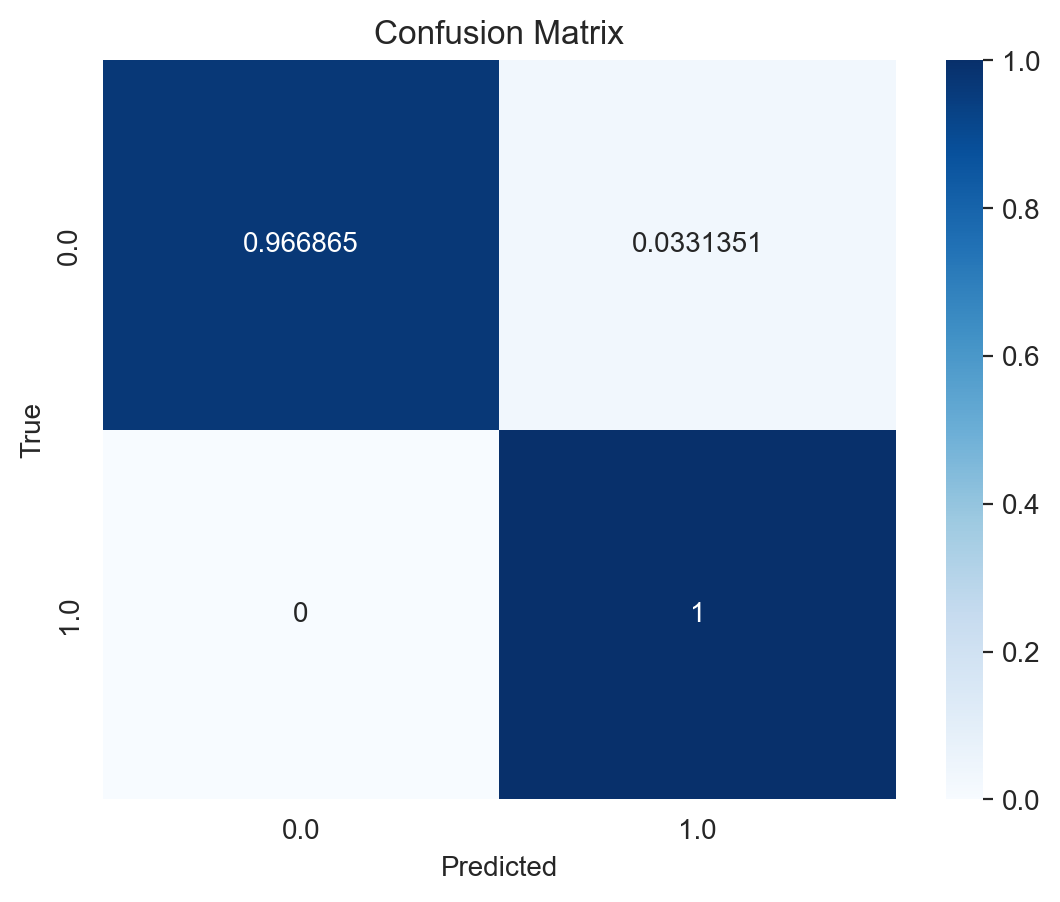

In [178]:
metrics_labels = [0, 1]
cm = confusion_matrix(y_true=real_lithologies_assignments, y_pred=k_means_assignments, normalize='true', labels=metrics_labels)

# Plot confusion matrix
classes = np.unique(real_lithologies_assignments)
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 0 correspond to shale 
# 1 correspond to sandstone

# **3. Conclusion**


The outcomes were notably positive as the K-means algorithm successfully clustered groups with a strong resemblance to well-defined lithologies. Remarkably, starting from just two initial random points, the algorithm achieved an impressive 97% accuracy when compared with the actual lithology interpretation. This success signifies new possibilities in reservoir geophysics classification strategies. However, it's important to note a limitation of the K-means algorithm: it tends to converge to a local optimum rather than a global one. Consequently, running the code multiple times may be necessary to attain optimal accuracy. One possible strategy to mitigage this problem, it's to inicialize the algorithm with points considered to be the average of the optimum clusters for the dataset.



# **References**

J. MacQueen, 1967. [Some Methods for classification and Analysis of Multivariate Observations](https://www.cs.cmu.edu/~bhiksha/courses/mlsp.fall2010/class14/macqueen.pdf)<br>

ANP, Superintendência de Definição de Blocos, 2017. [BACIA DO RECÔNCAVO](https://www.gov.br/anp/pt-br/rodadas-anp/rodadas-concluidas/concessao-de-blocos-exploratorios/14a-rodada-licitacoes-blocos/arquivos/areas-oferta/sumario-reconcavo.pdf)<br>
